# Defining each column
| Column                     | Description                                                                 |
|----------------------------|-----------------------------------------------------------------------------|
| ID                         | Client loan application ID                                                  |
| year                       | Year of loan application                                                    |
| loan_limit                 | Indicates if the loan is conforming (cf) or non-conforming (ncf)           |
| Gender                     | Gender of the applicant (male, female, joint, sex not available)           |
| approv_in_adv              | Whether the loan was approved in advance (pre, nopre)                      |
| loan_type                  | Type of loan (type1, type2, type3)                                         |
| loan_purpose               | Purpose of the loan (p1, p2, p3, p4)                                       |
| Credit_Worthiness         | Credit worthiness category (l1, l2)                                        |
| open_credit                | Whether the applicant has open credit accounts (opc, nopc)                 |
| business_or_commercial     | If the loan is for business/commercial use (ob/c) or personal (nob/c)      |
| loan_amount                | Amount of money borrowed                                                   |
| rate_of_interest           | Interest rate charged on the loan                                          |
| Interest_rate_spread       | Difference between loan interest and benchmark rate                        |
| Upfront_charges            | Initial charges for securing the loan                                      |
| term                       | Duration of the loan in months                                             |
| Neg_ammortization          | Whether loan allows negative amortization (neg_amm, not_neg)              |
| interest_only              | If the loan is interest-only (int_only, not_int)                           |
| lump_sum_payment           | Whether a lump sum is required at end (lpsm, not_lpsm)                     |
| property_value             | Value of the property financed                                             |
| construction_type          | Type of construction (sb - site built, mh - manufactured home)            |
| occupancy_type             | Occupancy type (pr, sr, ir)                                                |
| Secured_by                 | Type of collateral securing the loan (home, land)                          |
| total_units                | Number of units in the property (1U, 2U, 3U, 4U)                            |
| income                     | Applicant’s annual income                                                  |
| credit_type                | Applicant’s credit source (CIB, CRIF, EXP, EQUI)                           |
| Credit_Score               | Applicant’s credit score                                                   |
| co-applicant_credit_type   | Co-applicant’s credit type (CIB, EXP, etc.)                                |
| age                        | Applicant’s age                                                            |
| submission_of_application  | How the application was submitted (to_inst, not_inst)                      |
| LTV                        | Loan-to-Value ratio                                                        |
| Region                     | Geographic region (North, south, central, North-East)                      |
| Security_Type              | Type of loan security (direct, indirect)                                   |
| Status                     | Target variable: 1 = defaulted, 0 = not defaulted                          |
| dtir1                      | Debt-to-Income ratio                                                       |


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.feature_selection import VarianceThreshold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

In [22]:
raw_data = pd.read_csv('data/Loan_Default.csv')
data1 = raw_data.copy(deep=True)

# Cleaning

In [23]:
low_NaN_values = (data1.isna().sum() / data1.shape[0]) < 0.01
cols_with_low_nans = low_NaN_values[low_NaN_values].index

data1 = data1.dropna(subset=cols_with_low_nans)

In [24]:
# imputing loan_limit based on loan_amount 

data1.loan_limit = data1.loan_limit.fillna(data1['loan_amount'].apply(lambda x : 'ncf' if x > 45000 else 'cf'))

# imputing loan_purpose based on loan_amount 
def assign_purpose(loan_amount):
    if loan_amount < 20000:
        return 'p2'
    elif loan_amount > 20000 and loan_amount < 29000:
        return 'p3'
    elif loan_amount > 29000 and loan_amount < 34000:
        return 'p1'

    else:
        return 'p4'

data1.loan_purpose = data1.loan_purpose.fillna(data1['loan_amount'].apply(assign_purpose))

In [25]:
# scaling numerical values using KNNImputer and IterativeImputer

categorical_cols = data1.select_dtypes(include=['object']).columns
numerical_cols = data1.select_dtypes(include=['float64', 'int64'])
scaler = StandardScaler()
data1[numerical_cols.columns] = scaler.fit_transform(data1[numerical_cols.columns])

# corr = numerical_cols.corr()
# sns.heatmap(corr, annot=True, fmt='.1f', cmap='coolwarm', square=True, linewidths=0.1)
# plt.show()

# strong correlations
# loan_amount, property_value 0.7
# loan_amount, income 0.5
# roi, roi_spread 0.6

#imputing income using iterative imputer
subset1 = data1[['income', 'loan_amount']]
imputer_it_1 = IterativeImputer(estimator=LinearRegression(), max_iter=10, random_state=42)
imputed1 = imputer_it_1.fit_transform(subset1)
data1['income'] = imputed1[:, 0] 

#imputing property_value using iterative imputer
subset2 = data1[['property_value', 'loan_amount']]
imputer_it_2 = IterativeImputer(estimator=LinearRegression(), max_iter=10, random_state=42)
imputed2 = imputer_it_2.fit_transform(subset2)
data1['property_value'] = imputed2[:, 0] 

#imputing other numerical values using knnimputer
# 'loan_amount', 'rate_of_interest', 'Interest_rate_spread',
       # 'Upfront_charges', 'term', 'property_value', 'income', 'Credit_Score',
       # 'LTV', 'dtir1'


KNNI_features = ['rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'LTV', 'dtir1']
knn_imputer = KNNImputer(n_neighbors=5)

subset = data1[KNNI_features].copy()
batch_size = 20000

imputed_batches = []
for i in range(0, len(subset), batch_size):
    batch = subset.iloc[i:i+batch_size]
    imputed = knn_imputer.fit_transform(batch)
    imputed_batches.append(pd.DataFrame(imputed, columns=KNNI_features))

data1[KNNI_features] = pd.concat(imputed_batches).reset_index(drop=True)


In [26]:
#drop all the remaining NaNs
data1.dropna(inplace=True)

# Handling Categorical Features

In [27]:
one_hot_cols = ['loan_type', 'approv_in_adv', 'loan_purpose', 'business_or_commercial', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'occupancy_type', 'submission_of_application', 'Region']
frequency_encode = ['Gender', 'Credit_Worthiness', 'credit_type', 'co-applicant_credit_type', 'age', 'total_units']
features_to_drop = ['construction_type', 'Secured_by', 'Security_Type', 'open_credit', 'loan_limit']

# one hot encode
data1 = pd.get_dummies(data1, columns=one_hot_cols, drop_first=True)

# frequency encode
for col in frequency_encode:
    freq = data1[col].value_counts(normalize=True)
    data1[col] = data1[col].map(freq)

data1.drop(columns=features_to_drop, inplace=True)

In [28]:
data1.isna().sum().sum()

0

In [29]:
y = data1['Status'].astype(int)

X = data1[['Gender', 'Credit_Worthiness', 'loan_amount',
       'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term',
       'property_value', 'total_units', 'income', 'credit_type',
       'Credit_Score', 'co-applicant_credit_type', 'age', 'LTV',
       'dtir1', 'loan_type_type2', 'loan_type_type3', 'approv_in_adv_pre',
       'loan_purpose_p2', 'loan_purpose_p3', 'loan_purpose_p4',
       'business_or_commercial_nob/c', 'Neg_ammortization_not_neg',
       'interest_only_not_int', 'lump_sum_payment_not_lpsm',
       'occupancy_type_pr', 'occupancy_type_sr',
       'submission_of_application_to_inst', 'Region_North-East',
       'Region_central', 'Region_south']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)

ensemble = VotingClassifier(estimators=[
    ('rf', rf), 
    ('knn', knn)
], voting='soft')

ensemble.fit(X_train, y_train)

y_pred = ensemble.predict(X_test)

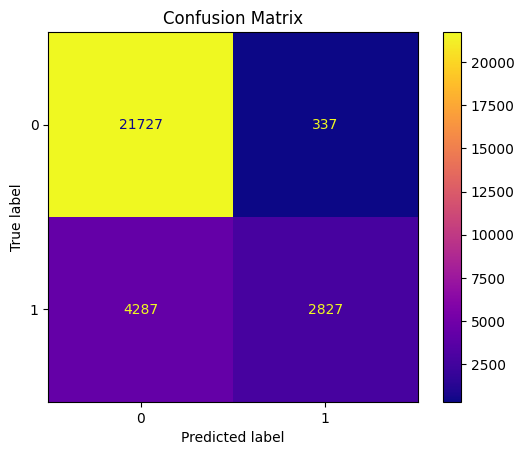

In [31]:
accuracy_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='plasma')
plt.title('Confusion Matrix')
plt.show()

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.98      0.90     22064
           1       0.89      0.40      0.55      7114

    accuracy                           0.84     29178
   macro avg       0.86      0.69      0.73     29178
weighted avg       0.85      0.84      0.82     29178



# Applying SMOTE for data unbalance

<Axes: xlabel='Status', ylabel='count'>

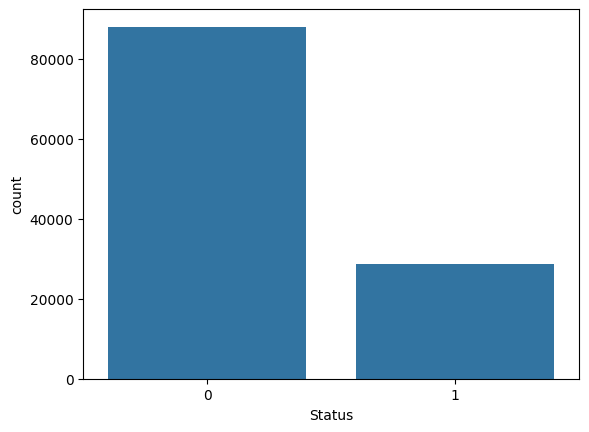

In [14]:
count_class = y_train.value_counts()
sns.barplot(count_class)

In [38]:
smote=SMOTE(sampling_strategy='minority') 
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

ensemble.fit(X_train_smote, y_train_smote)

y_pred_smote = ensemble.predict(X_test)

In [39]:
print(classification_report(y_test, y_pred_smote))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87     22064
           1       0.59      0.54      0.57      7114

    accuracy                           0.80     29178
   macro avg       0.72      0.71      0.72     29178
weighted avg       0.79      0.80      0.79     29178

